# Банки — Анализ оттока клиентов

Датасет содержит данные о клиентах банка «Метанпром». 
Банк располагается в Ярославле и областных городах: Ростов Великий и Рыбинск.

**Задача**:
1. Проанализировать клиентов банка.
2. Выделить портрет клиентов, которые склонны уходить из банка.
3. Проверить гипотезы о различии в балансе и доходе клиентов, которые ушли и которые остались.
4. Сделать на основании полученных данных предложения об удержании клиентов.

**Описание датасета**

* `userid` — идентификатор пользователя,
* `score` — баллы кредитного скоринга,
* `City` — город,
* `Gender` — пол,
* `Age` — возраст,
* `Objects` — количество объектов в собственности,
* `Balance` — баланс на счёте,
* `Products` — количество продуктов, которыми пользуется клиент,
* `CreditCard` — есть ли кредитная карта,
* `Loyalty` — активный клиент,
* `estimated_salary` — заработная плата клиента,
* `Churn` — ушёл или нет.

## Библиотеки, функции

In [1]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)

import scipy.stats as st

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# функция обзора основных данных файлов
def overview(data):
    print('\033[1m'+'Первые 5 строк таблицы')
    display(data.head(5).T)
    print()
    print('\033[1m'+'Случайные 5 строк таблицы')
    display(data.sample(5).T)
    print()
    print('\033[1m'+ 'Общая информация:'+'\033[0m')
    print()
    display(data.info())
    print('\033[1m'+'Доля пропусков в данных:'+'\033[0m')
    print()
    display(round((data).isna().mean()*100,2))

In [3]:
# функция для подсчета количества пропусков Balance в зависимости от столбца датасета, 
# сгруппированного по уникальным значениям.
def balance_null(df,columns):
    for i in columns:
        print('Доля пропущенных значений в столбце', i)
        df_temp =df.groupby(i)['balance', 'userid'].count().rename(columns={'balance': 'count_null', 'userid':'total'})
        df_temp['balance_nul'] = (df_temp['total'] - df_temp['count_null']) /df_temp['total']
        display(df_temp.style.format({'balance_nul':'{:.0%}'}))

## Предобработка данных

In [4]:
try:
    df = pd.read_csv('bank_dataset.csv')
except:
    df = pd.read_csv('/datasets/bank_dataset.csv')

In [5]:
overview(df)

Первые 5 строк таблицы


,0,1,2,3,4
userid,15677338,15690047,15662040,15744090,15780624
score,619,608,502,699,850
City,Ярославль,Рыбинск,Ярославль,Ярославль,Рыбинск
Gender,Ж,Ж,Ж,Ж,Ж
Age,42,41,42,39,43
Objects,2,1,8,1,2
Balance,NaN,"83,807.86","159,660.80",NaN,"125,510.82"
Products,1,1,3,2,1
CreditCard,1,0,1,0,1
Loyalty,1,1,0,0,1



Случайные 5 строк таблицы


,5287,3124,3817,2009,6131
userid,15845814,15837960,15766987,15775653,15792137
score,635,760,682,729,686
City,Рыбинск,Ярославль,Ростов Великий,Ростов Великий,Ярославль
Gender,Ж,М,Ж,М,М
Age,38,39,29,46,60
Objects,1,6,6,5,9
Balance,NaN,"178,585.46","101,012.77","117,837.43",NaN
Products,2,1,1,1,3
CreditCard,1,1,0,1,1
Loyalty,0,0,0,0,1



Общая информация:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


None

Доля пропусков в данных:



userid              0.00
score               0.00
City                0.00
Gender              0.00
Age                 0.00
Objects             0.00
Balance            36.17
Products            0.00
CreditCard          0.00
Loyalty             0.00
estimated_salary    0.00
Churn               0.00
dtype: float64

In [6]:
df.columns = df.columns.str.lower()

In [7]:
display(df[df.duplicated()])

,userid,score,city,gender,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn


Явных дубликатов не выявлено.

**Проанализируем причины возникновения пропусков в столбце `balance` и примем решение о заполнении пропусков**

In [8]:
df.corrwith(df['balance'], axis=0, method='pearson')\
    .to_frame().T.style.format('{:.0%}').background_gradient(cmap='Blues')

,userid,score,age,objects,balance,products,creditcard,loyalty,estimated_salary,churn
0,-1%,-0%,-1%,1%,100%,-0%,1%,-2%,-0%,2%


Выраженной линейной зависимости баланса и других признаков не выявлено.

Посмотрим количество пропущенных значений в столбце `balance` в разбивке по признакам, которые имеют небольшое количество уникальных значений, чтобы можно увидеть какие-либо закономерности. В столбцах с очень большим количеством уникальных значений выборка будет не репрезентативна, так как на каждое уникальное значение будет приходится немного пользователей, и сложно будет корректно установить взаимосвязь.

In [9]:
# столбцы с небольшим количеством уникальных значений
col = ['city', 'gender', 'objects',
       'products', 'creditcard', 'loyalty', 'churn']
balance_null(df,col)

Доля пропущенных значений в столбце city


,count_null,total,balance_nul
city,,,
Ростов Великий,2509,2509,0%
Рыбинск,1278,2477,48%
Ярославль,2596,5014,48%


Доля пропущенных значений в столбце gender


,count_null,total,balance_nul
gender,,,
Ж,2889,4543,36%
М,3494,5457,36%


Доля пропущенных значений в столбце objects


,count_null,total,balance_nul
objects,,,
0,276,413,33%
1,686,1035,34%
2,666,1048,36%
3,657,1009,35%
4,620,989,37%
5,638,1012,37%
6,600,967,38%
7,642,1028,38%
8,662,1025,35%


Доля пропущенных значений в столбце products


,count_null,total,balance_nul
products,,,
1,4179,5084,18%
2,1990,4590,57%
3,168,266,37%
4,46,60,23%


Доля пропущенных значений в столбце creditcard


,count_null,total,balance_nul
creditcard,,,
0,1920,2945,35%
1,4463,7055,37%


Доля пропущенных значений в столбце loyalty


,count_null,total,balance_nul
loyalty,,,
0,3105,4849,36%
1,3278,5151,36%


Доля пропущенных значений в столбце churn


,count_null,total,balance_nul
churn,,,
0,4846,7963,39%
1,1537,2037,25%


**Пропуски в данных столбца `Balance` могут быть связаны:**
1. С проблемами/ ошибками выгрузки/ввода данных в системе г.Ярославль и г. Рыбинск. Доля пропусков в данных 48%. Такой проблемы нет в данных г. Ростов Великий. Возможно, проблема связана с техническим сбоем, и нужно передать информацию бэк-офису о выявленной проблеме выгрузки данных. 
2. Также, возможно, с технической стороной вопроса ввода данных клиентов с 2-3 продуктами. У клиентов с 2 продуктами доля пропусков составляет 57%.

Таким образом, не вижу целесообразности заполнять пропуски в данных столбца `Balance`, так как нет четкой взаимосвязи с другими столбцами, а заполнение средним или медианой приведет к большому количеству выбросов и, следовательно, к некорректным выводам.

In [10]:
# Заменим значение столбца gender на бинарные
df['gender_bool'] = (df['gender'] == 'М').astype(int)
# Представим столбцы city в множество бинарных полей:
df_new = df.loc[:,['churn', 'city', 'age', 'gender_bool','objects', 'products', 
               'creditcard', 'loyalty','score', 'estimated_salary', 'balance'
              ]
           ]
df_new = (pd.get_dummies(df_new)
          .rename(columns={'city_Ростов Великий': 'city_RV', 
                           'city_Рыбинск': 'city_R', 
                           'city_Ярославль': 'city_Y', 
                          }
                 )
         )
df_new.head(10)

,churn,age,gender_bool,objects,products,creditcard,loyalty,score,estimated_salary,balance,city_RV,city_R,city_Y
0,1,42,0,2,1,1,1,619,"101,348.88",NaN,0,0,1
1,0,41,0,1,1,0,1,608,"112,542.58","83,807.86",0,1,0
2,1,42,0,8,3,1,0,502,"113,931.57","159,660.80",0,0,1
3,0,39,0,1,2,0,0,699,"93,826.63",NaN,0,0,1
4,0,43,0,2,1,1,1,850,"79,084.10","125,510.82",0,1,0
5,1,44,1,8,2,1,0,645,"149,756.71","113,755.78",0,1,0
6,0,50,1,7,2,1,1,822,"10,062.80",NaN,0,0,1
7,1,29,0,4,4,1,0,376,"119,346.88","115,046.74",1,0,0
8,0,44,1,4,2,0,1,501,"74,940.50","142,051.07",0,0,1
9,0,27,1,2,1,1,1,684,"71,725.73","134,603.88",0,0,1


### Вывод

Произведена предобработка данных:
1. Дубликаты не выявлены.
3. Обнаружено 36% пропусков в столбце `Balance`. Наличие пропусков скорее всего связано с техническими проблемами в г. Ярославль и г. Рыбинск, также возможно проблема отображения баланса связана с багами при вводе 2-3 продуктов у клиентов. Следует довести данную информацию до технической службы. Принято решение не заполнять пропуски и не удалять строки с пропусками, так как потеряется слишком много информации.

## Исследовательский анализ данных

In [11]:
df_new.describe().T

,count,mean,std,min,25%,50%,75%,max
churn,"10,000.00",0.20,0.40,0.00,0.00,0.00,0.00,1.00
age,"10,000.00",38.92,10.49,18.00,32.00,37.00,44.00,92.00
gender_bool,"10,000.00",0.55,0.50,0.00,0.00,1.00,1.00,1.00
objects,"10,000.00",5.01,2.89,0.00,3.00,5.00,7.00,10.00
products,"10,000.00",1.53,0.58,1.00,1.00,1.00,2.00,4.00
creditcard,"10,000.00",0.71,0.46,0.00,0.00,1.00,1.00,1.00
loyalty,"10,000.00",0.52,0.50,0.00,0.00,1.00,1.00,1.00
score,"10,000.00",650.53,96.65,350.00,584.00,652.00,718.00,850.00
estimated_salary,"10,000.00","100,090.24","57,510.49",11.58,"51,002.11","100,193.91","149,388.25","199,992.48"
balance,"6,383.00","119,827.49","30,095.06","3,768.69","100,181.98","119,839.69","139,512.29","250,898.09"


1. `churn`: 20% клиентов из выборки ушло из банка.
2. `age`: медианный возраст клиентов банка - 37 лет. Диапазон значений по выборке: от 18 до 92 лет.
3. `gender`: Распределение по половому признаку: 55% - мужчины, 45% - женщины.
4. `objects`: в среднем у клиентов банка в собственности 5 объектов.
5. `products`: клиенты пользуются 1 продуктом банка (медианное значение).
6. `creditcard`: 71% клиентов пользуются кредитными картами.
7. `loyalty`: 52% считаются лояльными банку.
8. `score`: cредний балл кредитного скоринга - 650. Диапазон значений скоринга по выборке: от 350 до 850 баллов.
9. `estimated_salary`: Средняя заработная плата клиентов из выборки - 100 тыс. руб.
10. `balance`: средний баланс счетов клиентов - 120 тыс. руб.
11. `city`: В выборку попали 50% клиентов из г. Ярославль и по 25% - из областных городов Ростов Великий и Рыбинск.

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.
По качественными признакам посчитаем среднее, а по количественным медиану:

In [12]:
#качественные признаки + отток
feature_bool = ['churn', 'creditcard', 'loyalty', 'city_RV', 'city_R', 'city_Y', 'gender_bool']
#количественные признаки + отток
feature_quantity = ['churn', 'score', 'age', 'objects', 'balance', 'products', 'estimated_salary']
df_new[feature_bool].groupby('churn').mean().T.style.format('{:.0%}')

churn,0,1
creditcard,71%,70%
loyalty,55%,36%
city_RV,21%,40%
city_R,26%,20%
city_Y,53%,40%
gender_bool,57%,44%


In [13]:
df_new[feature_quantity].groupby('churn').median().T

churn,0,1
score,653.00,646.00
age,36.00,45.00
objects,5.00,5.00
balance,"119,791.21","119,948.09"
products,2.00,1.00
estimated_salary,"99,645.04","102,460.84"


В основном уходят:
* нелояльные клиенты банка;
* жители города Ростов Великий;
* чаще женщины, чем мужчины;
* клиенты, медианный возраст которых более 45 лет;
* клиенты, которых только 1 продукт.

**Посмотрим распределения признаков для тех клиентов, кто ушёл (отток) и тех, кто остался.**

Оценим качественные признаки:

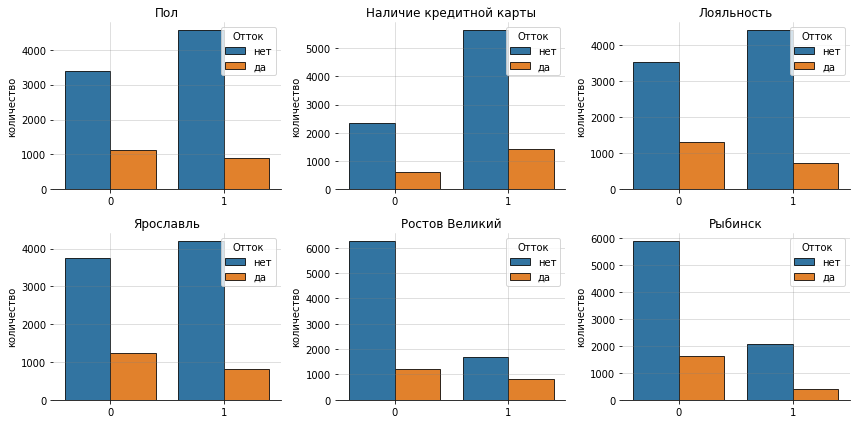

In [14]:
feature_bool_title = ['Пол','Наличие кредитной карты', 'Лояльность', 'Ярославль','Ростов Великий', 'Рыбинск']
feature_bool = ['gender_bool','creditcard', 'loyalty', 'city_Y','city_RV', 'city_R']

# графики качественных признаков
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6), squeeze=False) 
axes = axes.ravel()  
cols = feature_bool 
titels = feature_bool_title
for col, ax, titel in zip(cols, axes, titels):
    sns.countplot(data=df_new, x=col, hue='churn',ax=ax)
    plt.setp(ax.patches, linewidth=0.8, edgecolor='black')
    ax.grid(color='grey', alpha=0.5, linewidth=0.5)
    sns.despine(left=True, right=True, top=True, ax=ax)
    ax.set_title(titel)
    ax.set_ylabel('количество')
    ax.set_xlabel('')
    ax.legend(title="Отток", labels=['нет', 'да'], loc='upper right')
fig.tight_layout()
plt.show()

**На основании графиков можно сделать вывод, что более склонны к оттоку:**
* женщины;
* клиенты, которые не пользуются кредитными картами;
* не лояльные клиенты;
* жители г. Ростов Великий. 

**Посмотрим на количественные признаки:**

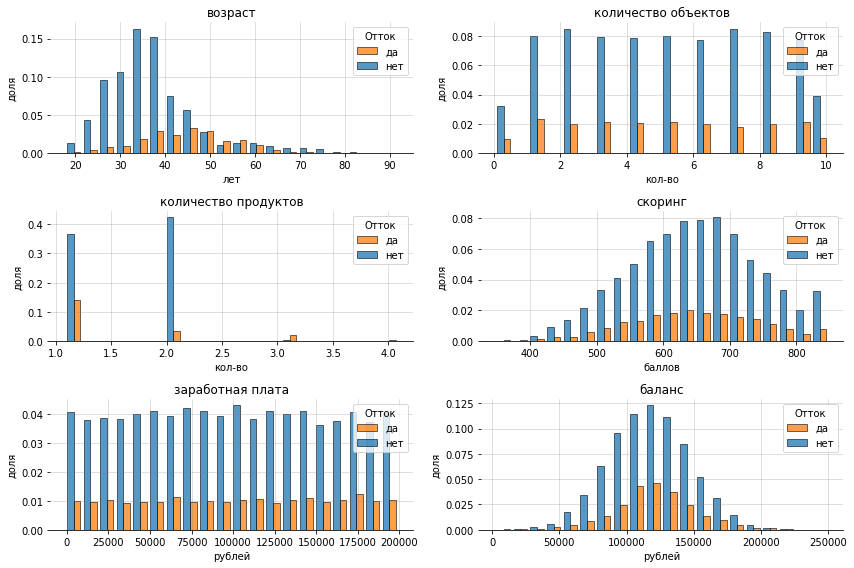

In [15]:
feature_quantity = ['age', 'objects', 'products', 'score', 'estimated_salary','balance']
feature_quantity_title = ['возраст', 'количество объектов', 'количество продуктов',
                         'скоринг', 'заработная плата', 'баланс']
feature_quantity_col = ['лет', 'кол-во', 'кол-во', 'баллов', 'рублей', 'рублей']

# графики количественных признаков
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8), squeeze=False) 
axes = axes.ravel()  
cols = feature_quantity 
titels = feature_quantity_title
x_names = feature_quantity_col
for col, ax, title, name in zip(cols, axes, titels, x_names):
    sns.histplot(data=df, x=col, hue='churn', multiple="dodge", shrink=.8, ax=ax, legend=False, bins=20, stat='probability')
    ax.grid(color='grey', alpha=0.5, linewidth=0.5)
    sns.despine(left=True, right=True, top=True, ax=ax)
    ax.set_title(title)
    ax.set_xlabel(name)
    ax.set_ylabel('доля')
    ax.legend(title="Отток", labels=['да', 'нет'], loc='upper right')
    
fig.tight_layout()
plt.show()

**На основании графиков можно сделать вывод, что более склонны к оттоку:**
* клиенты старше 44 лет и стоит предложить им какую-то программу;
* клиенты с 3-4 продуктами, возможно проблема связана с обслуживанием нескольких продуктов. Также клиенты только с одним продуктом более склонны к оттоку, чем с двумя продуктами;
* количество объектов в собственности, баллы скоринга, заработная плата и баланс практически не влияют на отток клиентов из банка.

**Посмотрим совместное распределение признаков отмеченных ранее, а именно:**
* возраст;
* пол;
* город обслуживания;
* наличие кредитных карт;
* лояльность;
* количество продуктов.

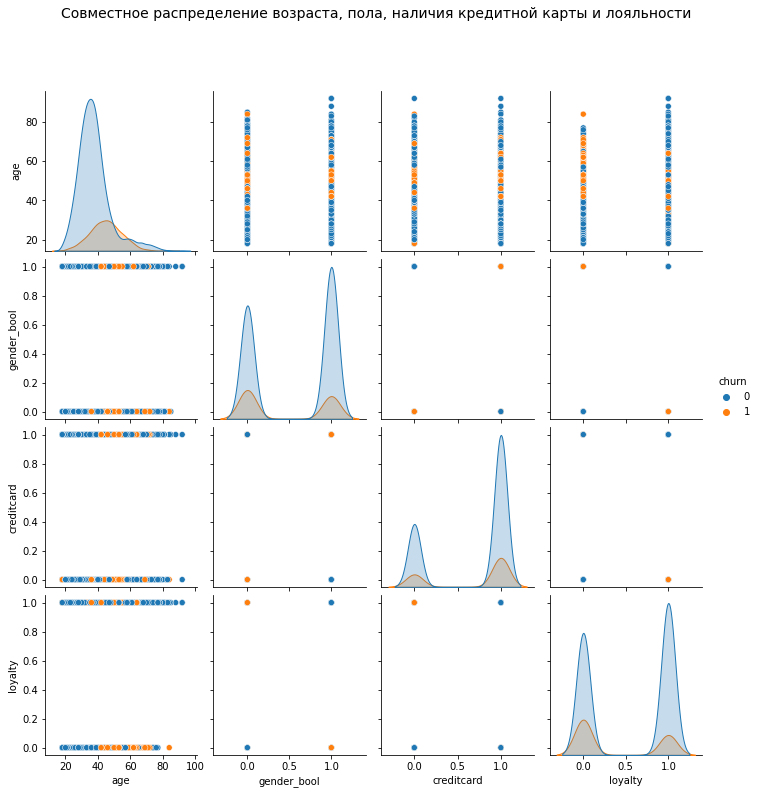

In [16]:
ax=sns.pairplot(df_new.loc[:,['churn', 'age', 'gender_bool', 'creditcard', 'loyalty']],
                hue='churn', diag_kind="kde")
ax.fig.suptitle("Cовместное распределение возраста, пола, наличия кредитной карты и лояльности", 
                y=1.1, fontsize = 14)
plt.show()

Из графика можно сделать вывод, что более склонны к оттоку:
1. Клиенты, старше 44 лет.
2. Женщины, у которых нет кредитной карты.
3. Мужчины с кредитной картой.
4. Лояльные женщины, чем нелояльные.
5. Лояльные клиенты без кредитной карты.

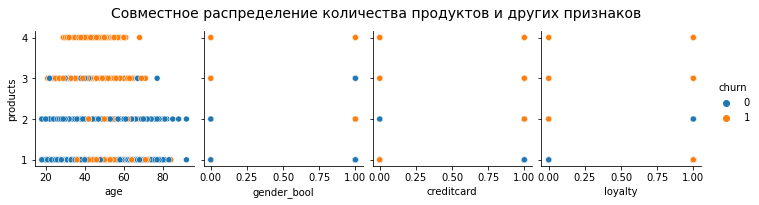

In [17]:
ax=sns.pairplot(data=df_new, 
            y_vars=['products'],
            x_vars=['age', 'gender_bool', 'creditcard', 'loyalty'],
             hue='churn')
ax.fig.suptitle("Cовместное распределение количества продуктов и других признаков", y=1.1, fontsize = 14)
plt.show()

Из графика можно сделать вывод, что более склонны к оттоку:
1. Клиенты, у котрых 3-4 продукта в банке.
2. Клиенты, у котрых единственный продукт не кредитная карта. Скорее всего клиент пользуется срочным продуктом и по окончанию срока уходит из банка.

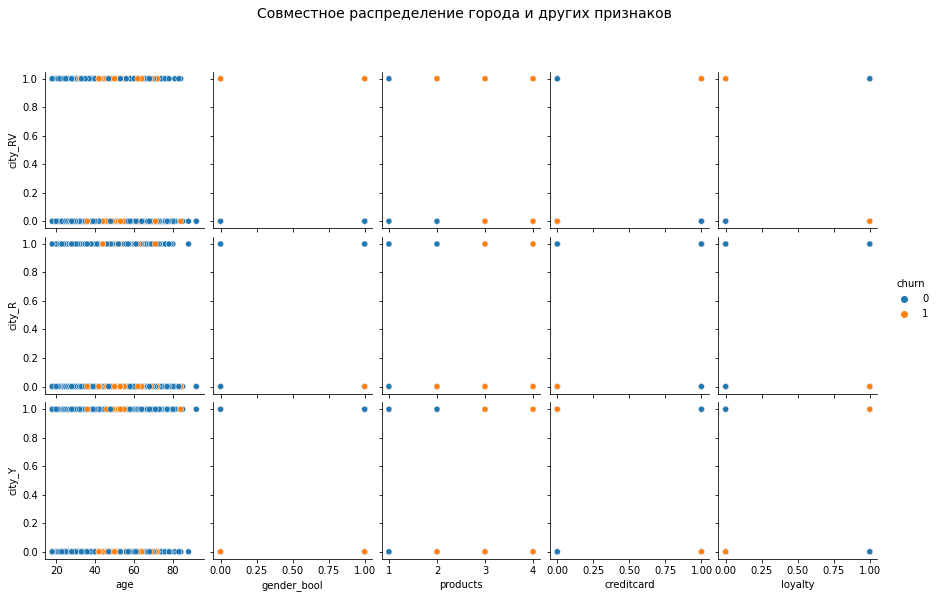

In [18]:
ax=sns.pairplot(data=df_new, 
            x_vars=['age', 'gender_bool', 'products', 'creditcard', 'loyalty'],
            y_vars=['city_RV', 'city_R', 'city_Y'],
             hue='churn')
ax.fig.suptitle("Cовместное распределение города и других признаков", y=1.1, fontsize = 14)
plt.show()

Из графика можно сделать вывод, что более склонны к оттоку:
1. В Ростове Великом:
    * и мужчины, и женщины;
    * пользователи более 1-го продукта;
    * пользователи кредитными картами;
    * нелояльные клиенты.

По городу можно сделать вывод, что есть проблема с обслуживанием клиентов. Новый клиент с одним продуктом уходит из банка. Скорее всего нужно решать проблему с персоналом банка в г. Ростов Великий.

2. В Рыбинске:
    * пользователи более 2-х продуктов;
    * пенсионеры, старше 60 лет. Возможно, это также связано с качеством обслуживания в офисах города. Нужна дополнительная информация для исследования данного вопроса.


3. В Ярославле:
    * пользователи более 2-х продуктов;
    * клиенты, старше 44 лет;
    * клиенты, у которых нет кредитной карты;
    * нелояльные клиенты.

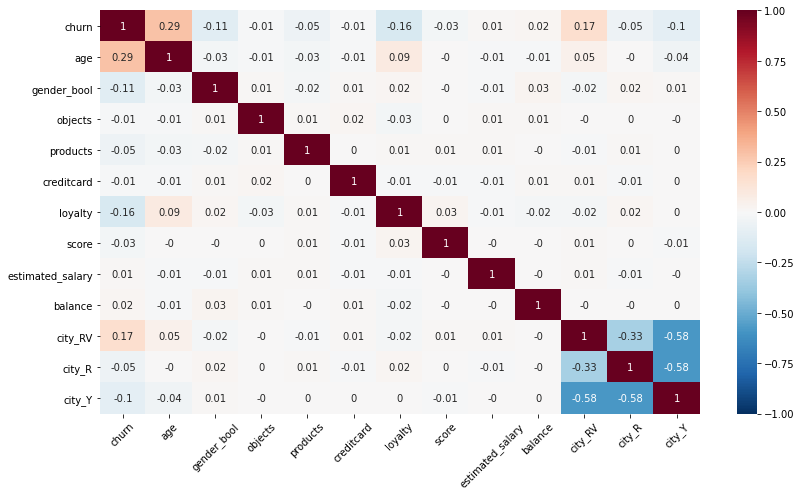

In [19]:
corr = df_new.corr().round(2)
# строим матрицу корреляций
plt.figure(figsize = (12,7))
sns.heatmap(corr, cmap=sns.color_palette("RdBu_r", 1000), vmin=-1, center=0, annot=True)
plt.xticks(rotation = 45)
plt.tight_layout()
plt.show()

Из матрицы корреляции видим, что небольшую линейную взаимосвязи с оттоком имеют следующие признаки в порядке убывания:
* возраст;
* город Ростов Великий, как место обслуживания клиентов. Прочие города имеют значительно менее выраженную взаимосвязь с оттоком;
* лояльность;
* пол;
* количество продуктов;
* прочие признаки практически не имеют линейной взаимосвязи с оттоком.

### Вывод

В результате исследовательского анализа данных можно взять следующие параметры для сегментации клиентов, для выявления более склонных к оттоку:
1. `age`: более склонны к оттоку клиенты старше 44 полных лет.
2. `city`: клиенты из г. Ростов Великий очень сильно склонны к оттоку, что скорее всего связано с качеством обслуживания в Банке. Клиенты г. Рыбинска более лояльно настроены к банку, чем в г. Ярославль, что также, возможно, связано с хорошим качеством обслуживания в банке.
3. `loyalty`: лояльные клиенты менее склонны к оттоку.
4. `gender`: более склонны к оттоку женщины.
5. `products`: пользователи более 2-х продуктов более склонны к оттоку. Также выявлена проблема оттока клиентов с одним продуктом, скорее всего они уходят после того, как заканчивается срок действия продукта. 
6. `creditcard`: клиенты, у которых оформлена кредитная карта менее склонны к оттоку, особенно женщины. При этом мужчины старше 44 лет с кредитной картой более склонны к оттоку, чем мужчины того же возраста без данного продукта.
7. Параметры `objects`, `score`, `estimated_salary`, `balance` не имеют сильно выраженного влияния на отток клиентов.

## Портрет клиента, склонного уходить из банка

На основании предыдущего анализа выделим группы клиентов наиболее склонные к уходу из банка:
1. Клиенты из Ростова Великого.
2. Клиенты, использующие более 2-х продуктов.
3. Мужчины старше 44 лет.
4. Мужчины старше 44 лет с кредитными картами.
5. Женщины старше 44 лет. 
6. Женщины старше 44 лет без кредитных карт.
7. Женщины без кредитных карт.
8. Пользователи одного продукта.

In [20]:
examples = [ ("пользователи одного продукта", 'products == 1'),
             ("клиенты из Ростова Великого", 'city == "Ростов Великий"'),
             ("пользователи 3 и 4 продуктов",'products > 2'),
             ("мужчины старше 44 лет", 'gender == "М" and age > 44'),
             ("мужчины старше 44 лет с кред картами", 'gender == "М" and age > 44 and creditcard == 1'),
             ("женщины старше 44 лет без кредитных карт", 
              'gender == "Ж" and age > 44 and creditcard == 0'),
             ("женщины старше 44 лет", 'gender == "Ж" and age > 44'),
             ("женщины без кредитных карт", 'gender == "Ж" and creditcard == 0'),   
]

# по заданным запросам делаем табличку с размерами разных групп и уровнем оттока
dfs_temp = []
for text, query in examples:
    result = df.query(query)\
               .agg({'churn':['mean','count']}).T
    result.index = [text]
    dfs_temp.append(result)
df_temp = pd.concat(dfs_temp)

# считаем превышение оттока над средним
df_temp = df_temp.rename(columns={'mean': 'mean_churn'})
df_temp['churn_suplus'] = df_temp['mean_churn'] - df.churn.mean()

# смотрим, сколько дополнительных уходящих клиентов мы можем обнаружить в этой группе
df_temp['user_churn_suplus'] = df_temp['count'] * df_temp['churn_suplus']

# считаем долю группы в общей выборке
count_all = df.userid.count()
df_temp['count_per_all'] = df_temp['count'] / count_all

# ранжируем по количетву дополнительных уходящих клиентов в группе и оформляем вывод
df_temp.sort_values('user_churn_suplus', ascending=False)\
       .drop(['user_churn_suplus'],axis=1)\
       .style.format('{:.1%}',subset=['count_per_all', 'mean_churn', 'churn_suplus'])\
       .format('{: .0f}',subset=['count'])

,mean_churn,count,churn_suplus,count_per_all
пользователи одного продукта,27.7%,5084,7.3%,50.8%
женщины старше 44 лет,51.1%,1149,30.7%,11.5%
клиенты из Ростова Великого,32.4%,2509,12.1%,25.1%
мужчины старше 44 лет,38.4%,1191,18.0%,11.9%
пользователи 3 и 4 продуктов,85.9%,326,65.5%,3.3%
мужчины старше 44 лет с кред картами,38.7%,827,18.3%,8.3%
женщины старше 44 лет без кредитных карт,55.1%,345,34.7%,3.5%
женщины без кредитных карт,25.5%,1351,5.1%,13.5%


### Вывод

На основании выделенных групп можно сделать следующие выводы:
1. Как правило, клиенты оформляют один продукт в банке, а по его окончанию уходят из банка. Стоит отслеживать таких клиентов и периодически предлагать им дополнительные релевантные продукты, которые есть на данный момент в Банке. А также, отслеживать окончание срока действия продукта и заблаговременно предлагать акции при оформление нового продукта:
    * например, сниженная ставка на кредит, как постоянному клиенту;
    * оформление дебетовой карты без комиссии на год;
    * бесплатная подписка на дополнительные услуги партнеров банка на 1-6 месяцев (сайты с кино, сериалами);
    * купоны на скидку у партнеров Банка.
2. Более половины (51%) клиентов в группе "Женщины старше 44 лет" уходит из банка. Причем доля уходящих женщин старше 44 лет без кредитных карт больше на 4%. Так как, на текущий момент частично данная группа относится к пенсионному возрасту, то можно предложить им специальные "пенсионные" продукты. Также можно применить повышенные ставки при условии перевода получения пенсии/зарплаты в Банк:
    * в первую очередь, стоит предложить им оформить кредитную карту в Банке;
    * пенсионные дебетовые карты с дополнительным кэшбеком на покупки в аптеках и супермаркетах, АЗС;
    * специальные накопительные счета;
    * специальные "пенсионные" вклады с дополнительной повышенной ставков;
    * страховые программы;
    * кредиты на строительство и ремонт дачных домов.
    
3. Доля мужчин старше 44 лет склонных к уходу из Банка - 38%. Им можно предложить аналогичные продукты, как и женщинам этого возраста за исключением кредитных карт, так как мужчины с кредитными картами в отличии от женщин более склонны к оттоку из Банка.
4. Уход клиентов из г. Ростов Великий скорее всего связано с качеством обслуживания, так как в других городах такая картина не наблюдается. Стоит организовать выездную проверку офисов с привлечением "тайных покупателей" в этом городе для выявления причин оттока клиентов.
5. Достаточно много клиентов, у которых более 2-х продуктов, уходят из банка. Возможно, это связано с неудобным интерфейсом использования продуктов. В этом отношении, стоит проработать дополнительную информацию, чтобы выявить пользователи каких продуктов более склонны к уходу и доработать их.

## Проверка гипотез

### Гипотеза различия дохода между теми клиентами, которые ушли, и теми, которые остались.

Проверим гипотезу различия дохода между теми клиентами, которые ушли, и теми, которые остались.

Сформулируем гипотезы:

𝐻0 : различий в доходе между клиентами, которые ушли, и теми, которые остались, нет.

Альтернативная гипотеза  𝐻1 : различия в доходе между группами есть.

Перед этим проверим подчиняются ли данные закону нормального распределения с помощью критерия Шапиро-Уилка.

Сформулируем гипотезы:

𝐻0 : Данные распределены нормально.

Альтернативная гипотеза  𝐻1 : Данные распределены не нормально.

In [21]:
sample_1 = df.query('churn == 0')['estimated_salary']

sample_2 = df.query('churn == 1')['estimated_salary']

alpha = 0.05 

print ('\033[1m'+'Проверка на нормальность распределения выборок'+'\033[0m')
print ('\033[1m'+'Данные о доходе клиентов, которые остались:'+'\033[0m')
print('p-значение: ', st.shapiro(sample_1)[1])

if st.shapiro(sample_1)[1] < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределено нормально') 

print ('')    
print ('\033[1m'+'Данные о доходе клиентов, которые ушли:'+'\033[0m')
print('p-значение: ', st.shapiro(sample_2)[1])

if st.shapiro(sample_2)[1] < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределено нормально') 

Проверка на нормальность распределения выборок
Данные о доходе клиентов, которые остались:
p-значение:  3.797518838320254e-43
Отвергаем нулевую гипотезу: распределение не нормально

Данные о доходе клиентов, которые ушли:
p-значение:  4.594104044877579e-25
Отвергаем нулевую гипотезу: распределение не нормально


Следовательно, применим непараметрический критерий Манна-Уитни, так как данные имеют не нормальное распределение.

In [22]:
# проверяем гипотезу критерием Манна-Уитни
alpha = .05 

results = st.mannwhitneyu(sample_1, sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.22705150930153783
Не получилось отвергнуть нулевую гипотезу


#### Вывод

Нет статистиченски значимых оснований отвергнуть нулевую гипотезу об отсутствии разницы в доходе между клиентами, которые ушли и которые остались.

### Гипотеза различия между балансом клиентов, которые ушли, и которые остались.

Сформулируем гипотезы:

𝐻0 : различий в балансе между клиентами, которые ушли, и теми, которые остались, нет.

Альтернативная гипотеза  𝐻1 : различия в балансе между группами есть.

In [23]:
# разделим данные на группы, при этом удалим пропуски данных
sample_1 = df.query('churn == 0')['balance'].dropna().reset_index(drop=True)
sample_2 = df.query('churn == 1')['balance'].dropna().reset_index(drop=True)

alpha = 0.05

print ('\033[1m'+'Проверка на нормальность распределение выборок'+'\033[0m')
print ('\033[1m'+'Данные о балансе клиентов, которые остались:'+'\033[0m')
print('p-значение: ', st.shapiro(sample_1)[1])

if st.shapiro(sample_1)[1] < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение нормально') 

print ('')    
print ('\033[1m'+'Данные о балансе клиентов, которые ушли:'+'\033[0m')
print('p-значение: ', st.shapiro(sample_2)[1])

if st.shapiro(sample_2)[1] < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
    print('Не получилось отвергнуть нулевую гипотезу, распределение нормально') 

Проверка на нормальность распределение выборок
Данные о балансе клиентов, которые остались:
p-значение:  0.8506813049316406
Не получилось отвергнуть нулевую гипотезу, распределение нормально

Данные о балансе клиентов, которые ушли:
p-значение:  1.0646013848258917e-08
Отвергаем нулевую гипотезу: распределение не нормально


Одна из выборок имеет не нормальное распределение, поэтому применим тест Манна-Уитни:

In [24]:
# проверяем гипотезу критерием Манна-Уитни
alpha = .05 # критический уровень статистической значимости

results = st.mannwhitneyu(sample_1, sample_2)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение: 0.22150885555919375
Не получилось отвергнуть нулевую гипотезу


#### Вывод

### Вывод

В результате проверки гипотез о разнице в доходе и балансе клиентов, которые ушли и которые остались, получили, что статистически значимой разницы между группами нет.

## Общие выводы

В результате анализа данных клиентов «Метанпром» можно сделать следующие выводы:

1. Признаки влияющие на отток клиентов:
    * `возраст`;
    * `город обслуживания`;
    * `лояльность`;
    * `пол`;
    * `количество используемых продуктов` в банке;
    * наличие `кредитной карты`;
2. Не имеют сильно выраженного влияния на отток клиентов:
    * `количество объектов` в собственности;
    * `скоринг`. Хотя при этом у ушедших клиентов ниже скоринговая оценка. И, возможно, прекращение обслуживания в банке связано с платежеспособностью таких клиентов;
    * `зарплата`. В результате проверки гипотез о разнице в доходе клиентов, которые ушли и которые остались, получили, что статистически значимой разницы между группами нет.
    * `баланс`. В результате проверки гипотез о разнице в балансе клиентов, которые ушли и которые остались, получили, что статистически значимой разницы между группами нет.

**Выделили следующие группы наиболее склонных к уходу клиентов:**
1. Клиенты из Ростова Великого.
2. Мужчины старше 44 лет.
3. Мужчины старше 44 лет с кредитными картами.
4. Женщины старше 44 лет. 
5. Женщины старше 44 лет без кредитных карт.
6. Женщины без кредитных карт.
7. Пользователи одного продукта.
8. Клиенты, использующие более 2-х продуктов.

**На основании выделенных групп можно сделать следующие выводы и предложения**:
1. Как правило, клиенты оформляют `один продукт` в Банке, а по его окончанию уходят. Стоит отслеживать таких клиентов и периодически предлагать им дополнительные релевантные продукты, которые есть на данный момент в Банке. А также, отслеживать окончание срока действия продукта и заблаговременно предлагать акции при оформление нового продукта:
    * например, сниженная ставка на кредит, как постоянному клиенту;
    * оформление дебетовой карты без комиссии на год;
    * бесплатная подписка на дополнительные услуги партнеров банка на 1-6 месяцев (сайты с кино, сериалами);
    * купоны на скидку у партнеров Банка.
    
    
2. Более половины (51%) клиентов в группе `"Женщины старше 44 лет"` уходит из банка. Причем доля уходящих женщин старше 44 лет без кредитных карт больше на 4%. Так как, на текущий момент частично данная группа относится к пенсионному возрасту, то можно предложить им специальные "пенсионные" продукты. Также можно применить повышенные ставки при условии перевода получения пенсии/зарплаты в Банк:
    * в первую очередь, стоит предложить им оформить кредитную карту в Банке;
    * пенсионные дебетовые карты с дополнительным кэшбеком на покупки в аптеках и супермаркетах, АЗС;
    * специальные накопительные счета;
    * специальные "пенсионные" вклады с дополнительной повышенной ставков;
    * страховые программы;
    * кредиты на строительство и ремонт дачных домов.
    
    
3. Доля `мужчин старше 44 лет`, склонных к уходу из Банка - 38%. Им можно предложить аналогичные продукты, как и женщинам этого возраста за исключением кредитных карт, так как мужчины с кредитными картами в отличии от женщин более склонны к оттоку из Банка.


4. Уход `клиентов из г. Ростов Великий` скорее всего связано с качеством обслуживания, так как в других городах такая картина не наблюдается. Стоит организовать выездную проверку офисов с привлечением "тайных покупателей" в этом городе для выявления причин оттока клиентов.


5. Достаточно много клиентов, у которых `более 2-х продуктов`, уходят из банка. Возможно, это связано с неудобным интерфейсом использования продуктов. В этом отношении, стоит проработать дополнительную информацию, чтобы выявить пользователи каких продуктов более склонны к уходу и доработать их.